In [ ]:
# Required libraries
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_rel
import scipy
import dowhy
from dowhy import CausalModel
import warnings
warnings.filterwarnings("ignore")

# Step 1: Generating the Synthetic Dataset
def generate_synthetic_dataset(y_transformation = "linear", T=3, k=32, sigma=0.01, n_samples=1000):
    np.random.seed(42)  # For reproducibility
    Z = np.zeros((n_samples, T, k))  # Autoregressive data
    A = np.random.binomial(1, 0.5, size=n_samples)  # Sensitive attribute
    # Initialize Z_T
    Z[:, -1, :] = np.random.normal(0, 1, size=(n_samples, k))

    xi_noise = [np.random.normal(0, sigma, size=(n_samples, k)) for _ in range(T - 1)]

    for t in reversed(range(T - 1)):
        M_t = np.random.uniform(-10, 10, size=(k, k))
        M_t /= np.linalg.norm(M_t, axis=1, ord=1, keepdims=True)
        N_t = np.random.uniform(10, 10, size=(k, k))
        N_t /= np.linalg.norm(N_t, axis=1, ord=1, keepdims=True)
        Z[:, t, :] = (M_t @ Z[:, t + 1, :].T * A + N_t @ Z[:, t + 1, :].T * (1 - A)).T + xi_noise[t]

    M_X = np.random.uniform(-1, 1, size=(k, k))
    r = np.random.uniform(-1, 1, size=k)
    epsilon_X = np.random.normal(0, sigma, size=(n_samples, k))
    X = (M_X @ Z[:, 0, :].T).T + r + epsilon_X
    if y_transformation == "linear":
        omega_Y = np.random.uniform(-1, 1, size=k) 
        b_Y = np.random.normal(-1.5, 1)
        logits_Y = (omega_Y @ Z[:, -1, :].T + b_Y).T  
    elif y_transformation == 'quadratic':
        omega_Y = np.random.uniform(-4, 4, size=k) 
        b_Y = np.random.normal(20, 1)
        logits_Y = (omega_Y @ (Z[:, -1, :].T)**2 + b_Y).T
    elif y_transformation == 'exponential':
        omega_Y = np.random.uniform(-1, 1, size=k)
        b_Y = np.random.normal(10, 1)
        logits_Y = (omega_Y @ np.exp(Z[:, -1, :].T) + b_Y).T
    elif y_transformation == "relu":
        omega_Y = np.random.uniform(-1, 1, size=k)
        b_Y = np.random.normal(0-1, 1)
        logits_Y = (omega_Y @ np.maximum(0, Z[:, -1, :].T) + b_Y).T
    elif y_transformation == "interactive":
        omega_Y = np.random.uniform(-1, 1, size=(k, k))
        b_Y = np.random.normal(0, 1)
        logits_Y = np.sum([omega_Y[i, j] * Z[:, -1, i] * Z[:, -1, j] for i in range(k) for j in range(k) if i != j], axis=0) + b_Y
    elif y_transformation == "log-exp":
        omega_Y = np.random.uniform(-1, 1, size=k) 
        b_Y = np.random.normal(5, 1)
        logits_Y = np.log(np.maximum(omega_Y @ Z[:, -1, :].T, 0.0001)) + b_Y
    elif y_transformation == 'sin':
        omega_Y = np.random.uniform(-1, 1, size=k)
        b_Y = np.random.normal(0, 1)
        logits_Y = (omega_Y @ np.sin(Z[:, -1, :].T) + b_Y).T
    
    Y_prob = 1 / (1 + np.exp(-logits_Y))
    #y = np.random.binomial(1, Y_prob)
    y = (Y_prob >= 0.5).astype(np.float32)


    A_ctf = 1 - A
    Z_ctf = np.zeros((n_samples, T, k))
    Z_ctf[:, -1, :] = Z[:, -1, :] 

    # Use the same noise xi_noise but with counterfactual A
    for t in reversed(range(T - 1)):
        M_t = np.random.normal(0, 1, size=(k, k))
        N_t = np.random.normal(0, 1, size=(k, k))
        Z_ctf[:, t, :] = (M_t @ Z_ctf[:, t + 1, :].T * A_ctf + N_t @ Z_ctf[:, t + 1, :].T * (1 - A_ctf)).T + xi_noise[t]
    X_ctf = (M_X @ Z_ctf[:, 0, :].T).T + r + epsilon_X

    return X, A, Z, y, X_ctf

In [102]:
X, A, Z, y, X_ctf = generate_synthetic_dataset(y_transformation = "linear", T = 2, n_samples = 2000)
X_train, X_test, A_train, A_test, Z_train, Z_test, y_train, y_test, _, X_ctf_test = train_test_split(X, A, Z, y, X_ctf, test_size=0.2, random_state=42)
y.sum(), y_train.sum(), y_test.sum()

(498.0, 399.0, 99.0)

In [104]:
def build_logistic_classifier(X, y, seed):
    model = LogisticRegression(random_state=seed)
    model.fit(X, y)
    return model

def build_svm_classifier(X, y, seed):
    model = LinearSVC(random_state=seed)
    model.fit(X, y)
    return model

# Step 4: Implement Demographic Parity Baseline
def demographic_parity_test(model, X, A, n_bootstrap=1000):
    f_X = model.predict(X)

    f_X_A0 = f_X[A == 0]
    f_X_A1 = f_X[A == 1]
    min_size = min(len(f_X_A0), len(f_X_A1))
    bootstrapped_A0 = np.random.choice(f_X_A0, size=n_bootstrap, replace=True)
    bootstrapped_A1 = np.random.choice(f_X_A1, size=n_bootstrap, replace=True)
    t_stat, p_val = ttest_rel(bootstrapped_A0, bootstrapped_A1)

    return t_stat, p_val


#Equal Opportunity
def equal_opportunity_test(model, X, A, Y, n_bootstrap=1000):
    f_X = model.predict(X)

    # Split based on Y and A
    f_X_Y0_A0 = f_X[(Y == 0) & (A == 0)]
    f_X_Y0_A1 = f_X[(Y == 0) & (A == 1)]
    f_X_Y1_A0 = f_X[(Y == 1) & (A == 0)]
    f_X_Y1_A1 = f_X[(Y == 1) & (A == 1)]

    f_X_A0 = np.concatenate([f_X_Y0_A0, f_X_Y1_A0])
    f_X_A1 = np.concatenate([f_X_Y0_A1, f_X_Y1_A1])

    bootstrapped_A0 = np.random.choice(f_X_A0, size=n_bootstrap, replace=True)
    bootstrapped_A1 = np.random.choice(f_X_A1, size=n_bootstrap, replace=True)

    t_stat, p_val = ttest_rel(bootstrapped_A0, bootstrapped_A1)

    return t_stat, p_val

In [105]:
from sklearn.metrics import accuracy_score

def test_accuracy(model, X_test, y_test):
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

model_svm = build_svm_classifier(X_train, y_train, seed = 0+1)
model_log = build_logistic_classifier(X_train, y_train, seed = 0+1)

print("svm acc:", test_accuracy(model_svm, X_test, y_test))
print("log acc:", test_accuracy(model_log, X_test, y_test))

svm acc: 0.8175
log acc: 0.8125


In [106]:
t_stat_dp, p_val_dp = demographic_parity_test(model_svm, X_test, A_test)
t_stat_eo, p_val_eo = equal_opportunity_test(model_svm, X_test, A_test, y_test)
print("model:svm")
print(f"Demographic parity: tstat: {t_stat_dp}, p-value:{p_val_dp}")
print(f"Equal Opportunity: tstat: {t_stat_eo}, p-value:{p_val_eo}")

model:svm
Demographic parity: tstat: -3.4121443990075577, p-value:0.0006703807782529389
Equal Opportunity: tstat: -3.132475635051078, p-value:0.0017838434523535598


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class g_estimator(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(g_estimator, self).__init__()
        self.mlp_0 = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        self.mlp_1 = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, Z, A):
        out_A0 = self.mlp_0(Z).squeeze(-1) 
        out_A1 = self.mlp_1(Z).squeeze(-1) 
        out = torch.where(A == 0, out_A0, out_A1)
        return torch.sigmoid(out)

def train_g_estimator(model:g_estimator, ZT_train, A_train, y_train, ZT_test, A_test, y_test, lr= 0.001, max_epoch=5000, verbose = False):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    Z_tensor = torch.tensor(ZT_train, dtype=torch.float32)
    A_tensor = torch.tensor(A_train, dtype=torch.float32)
    y_pred_tensor = torch.tensor(y_train, dtype=torch.float32)
    log_every_n_epoch = max_epoch // 10

    model.train()
    for epoch in range(max_epoch):
        optimizer.zero_grad()
        g_pred = model(Z_tensor, A_tensor)
        loss = criterion(g_pred.squeeze(), y_pred_tensor)
        loss.backward()
        optimizer.step()
        if verbose and (epoch % log_every_n_epoch == 0):
            print(f'Epoch {epoch}/{max_epoch}, Loss: {loss.item()}')
    
    model.eval()
    with torch.no_grad():
        Z_test_tensor = torch.tensor(ZT_test, dtype=torch.float32)
        A_test_tensor = torch.tensor(A_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
        
        g_test_pred = model(Z_test_tensor, A_test_tensor)
        predicted_labels = (g_test_pred.squeeze() > 0.5).float()
        accuracy = (predicted_labels == y_test_tensor).float().mean().item()
        
        #print(f'Test Accuracy: {accuracy * 100:.2f}%')

class h_estimator(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(h_estimator, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, z):
        #print(z.shape)
        out = torch.sigmoid(self.mlp(z)).squeeze(-1)
        return out
    
def train_h_estimator(model:h_estimator, ZT_train, y_train, ZT_test, y_test, lr= 0.001, max_epoch=100, verbose = True):
    #print("train h(z) estimator")
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    Z_tensor = torch.tensor(ZT_train, dtype=torch.float32)
    y_pred_tensor = torch.tensor(y_train, dtype=torch.float32)

    model.train()
    for epoch in range(max_epoch):
        optimizer.zero_grad()
        h_pred = model(Z_tensor)
        loss = criterion(h_pred.squeeze(), y_pred_tensor)
        loss.backward()
        optimizer.step()
        if verbose and  (epoch % 100 == 0):
            print(f'Epoch {epoch}/{max_epoch}, Loss: {loss.item()}')
    
    model.eval()
    with torch.no_grad():
        Z_test_tensor = torch.tensor(ZT_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
        
        h_test_pred = model(Z_test_tensor)
        predicted_labels = (h_test_pred.squeeze() > 0.5).float()
        accuracy = (predicted_labels == y_test_tensor).float().mean().item()
        
        #print(f'Test Accuracy: {accuracy * 100:.2f}%')

def ci_test_method(model, X_train, A_train, ZT_train, X_test, A_test, ZT_test, y_test):
    # Learn the functions g(a, Z) and h(Z)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    z_dim = ZT_train.shape[1]
    g_model = g_estimator(z_dim = z_dim, hidden_dim = z_dim // 2)
    train_g_estimator(g_model, ZT_train, A_train, y_pred_train, ZT_test, A_test, y_pred_test, lr = 0.001, max_epoch=1000, verbose = False)
    h_model = h_estimator(z_dim = z_dim, hidden_dim = z_dim // 2)
    train_h_estimator(h_model, ZT_train, y_pred_train, ZT_test = ZT_test, y_test = y_pred_test, lr = 0.001, max_epoch=1000, verbose = False)

    # Compute test statistics
    g_vals = y_pred_test * g_model(torch.tensor(ZT_test, dtype=torch.float32), torch.tensor(A_test, dtype=torch.float32)).detach().numpy()
    h_vals = y_pred_test * h_model(torch.tensor(ZT_test, dtype=torch.float32)).detach().numpy()
    #print(g_vals.shape, h_vals.shape)
    t_stat, p_val = ttest_rel(g_vals, h_vals)

    return t_stat, p_val

ci_test_method(model_svm, X_train, A_train, Z_train[:,0,:], X_test, A_test, Z_test[:,0,:], y_test)

Test Accuracy: 93.25%
Test Accuracy: 85.75%


In [32]:
g_model = g_estimator(z_dim = Z_train.shape[2], hidden_dim = Z_train.shape[2] // 2)
train_g_estimator(g_model, Z_train[:, -1, :], A_train, y_train, Z_test[:, -1, :], A_test, y_test, lr = 0.001, max_epoch=2000)

Test Accuracy: 93.00%


In [ ]:
h_model = h_estimator(z_dim = Z_train.shape[2], hidden_dim = Z_train.shape[2] // 2)
train_h_estimator(h_model, Z_train[:, -1, :], y_train, ZT_test = Z_test[:, -1, :], y_test = y_test, lr = 0.001, max_epoch=2000)

Epoch 0/1000, Loss: 0.7178475260734558
Epoch 100/1000, Loss: 0.5496150851249695
Epoch 200/1000, Loss: 0.07102912664413452
Epoch 300/1000, Loss: 0.013312704861164093
Epoch 400/1000, Loss: 0.004642222076654434
Epoch 500/1000, Loss: 0.0021781937684863806
Epoch 600/1000, Loss: 0.0012278018984943628
Epoch 700/1000, Loss: 0.0007811348768882453
Epoch 800/1000, Loss: 0.0005382733652368188
Epoch 900/1000, Loss: 0.00039175007259473205
Test Accuracy: 95.50%


In [109]:
def empirical_counterfactual_accuracy(model, X_test, X_ctf_test):
    pred = model.predict(X_test)
    pred_ctf = model.predict(X_ctf_test)
    matches = (pred == pred_ctf).astype(int)
    t_stat, p_val = ttest_rel(pred, pred_ctf)
    acc = np.mean(matches)
    return acc, t_stat, p_val

def evaluate_model(model, X_train, A_train, Z_train, X_test, A_test, Z_test, y_test, X_ctf_test):
    t_stat_ci, p_val_ci = ci_test_method(model, X_train, A_train, Z_train[:,1,:], X_test, A_test, Z_test[:,1,:], y_test)
    t_stat_dp, p_val_dp = demographic_parity_test(model, X_test, A_test)
    t_stat_eo, p_val_eo = equal_opportunity_test(model, X_test, A_test, y_test)
    acc, t_stat_ca, p_val_ca = empirical_counterfactual_accuracy(model, X_test, X_ctf_test)

    #print(f"CI Test: t-stat={t_stat_ci}, p-value={p_val_ci}")
    #print(f"Demographic Parity Test: t-stat={t_stat_dp}, p-value={p_val_dp}")
    #print(f"Equal Opportunity Test: t-stat={t_stat_eo}, p-value={p_val_eo}")
    #print(f"Empirical Counterfactual Accuracy (ECA): {acc}, t-stat={t_stat_ca}, p-value={p_val_ca}")

    # Output results in a comparative table format
    results = {
        'CI Test': {'t-stat': t_stat_ci, 'p-value': p_val_ci},
        'Demographic Parity': {'t-stat': t_stat_dp, 'p-value': p_val_dp},
        'Equal Opportunity': {'t-stat': t_stat_eo, 'p-value': p_val_eo},
        'ECA': {'t-stat': t_stat_ca, 'p-value': p_val_ca, 'acc':acc}
    }
    
    return results

In [110]:
evaluate_model(model_svm, X_train, A_train, Z_train, X_test, A_test, Z_test, y_test, X_ctf_test)

Test Accuracy: 93.25%
Test Accuracy: 87.25%


{'CI Test': {'t-stat': 3.8236629963242255, 'p-value': 0.00015250906135381783},
 'Demographic Parity': {'t-stat': -3.7336287420688894,
  'p-value': 0.0001994029758996407},
 'Equal Opportunity': {'t-stat': -3.5704376645542335,
  'p-value': 0.0003733542023980693},
 'ECA': {'t-stat': -9.730991715012278,
  'p-value': 3.197939299839394e-20,
  'acc': 0.515}}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns

# Step 1: Define the models to evaluate
def create_model_pool(n_models_each = 20):
    models = []
    seeds = list(range(n_models_each))  # 10 random seeds
    for seed in seeds:
        models.extend(
            [
                LinearSVC(random_state=seed),
                LogisticRegression(random_state=seed),
                DecisionTreeClassifier(random_state=seed),
                RandomForestClassifier(n_estimators=50, random_state=seed),
                GradientBoostingClassifier(n_estimators=100, random_state=seed),
                DecisionTreeClassifier(max_depth=5, random_state=seed),
                MLPClassifier(hidden_layer_sizes=(16, 8, 4), max_iter=500, random_state=seed),
                MLPClassifier(hidden_layer_sizes=(16, 4), max_iter=500, random_state=seed)
            ]
        )
    
    return models

# Step 2: Evaluate each model
def evaluate_model_pool(models, X_train, A_train, Z_train, X_test, A_test, Z_test, y_test, X_ctf_test):
    results = {'CI Test': [], 'Demographic Parity': [], 'Equal Opportunity': [], 'ECA': []}
    
    for model in models:
        model.fit(X_train, y_train)
        res = evaluate_model(model, X_train, A_train, Z_train, X_test, A_test, Z_test, y_test, X_ctf_test)
        results['CI Test'].append(res['CI Test']['p-value'])
        results['Demographic Parity'].append(res['Demographic Parity']['p-value'])
        results['Equal Opportunity'].append(res['Equal Opportunity']['p-value'])
        results['ECA'].append(res['ECA']['acc'])
    
    return results

def plot_correlations(results):
    # Log-transform the p-values for plotting
    ci_log_pvals = np.log10(results['CI Test']).squeeze()
    dp_log_pvals = np.log10(results['Demographic Parity']).squeeze()
    eo_log_pvals = np.log10(results['Equal Opportunity']).squeeze()
    eca_vals = np.array(results['ECA'])

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    sns.scatterplot(x=eca_vals, y=ci_log_pvals, ax=axes[0], markers='s')
    axes[0].set_title('Log p-value: CI Test vs. ECA')
    axes[0].set_xlabel('ECA')
    axes[0].set_ylabel('Log(CI Test p-value)')

    sns.scatterplot(x=eca_vals, y=dp_log_pvals, ax=axes[1])
    axes[1].set_title('Log p-value: Demographic Parity vs. ECA')
    axes[1].set_xlabel('ECA ')
    axes[1].set_ylabel('Log(DP p-value)')

    sns.scatterplot(x=eca_vals, y=eo_log_pvals, ax=axes[2])
    axes[2].set_title('Log p-value: Equal Opportunity vs. ECA')
    axes[2].set_xlabel('ECA')
    axes[2].set_ylabel('Log(EO p-value)')

    plt.tight_layout()
    plt.show()

In [ ]:
X, A, Z, y, X_ctf = generate_synthetic_dataset(y_transformation = "linear")
X_train, X_test, A_train, A_test, Z_train, Z_test, y_train, y_test, _, X_ctf_test = train_test_split(X, A, Z, y, X_ctf, test_size=0.2, random_state=42)
models = create_model_pool(n_models_each=1)
linear_results = evaluate_model_pool(models, X_train, A_train, Z_train, X_test, A_test, Z_test, y_test, X_ctf_test)
plot_correlations(linear_results)

In [ ]:
X, A, Z, y, X_ctf = generate_synthetic_dataset(y_transformation = "quadratic")
X_train, X_test, A_train, A_test, Z_train, Z_test, y_train, y_test, _, X_ctf_test = train_test_split(X, A, Z, y, X_ctf, test_size=0.2, random_state=42)
models = create_model_pool()
quad_results = evaluate_model_pool(models, X_train, A_train, Z_train, X_test, A_test, Z_test, y_test, X_ctf_test)

In [ ]:
X, A, Z, y, X_ctf = generate_synthetic_dataset(y_transformation = "exponential")
X_train, X_test, A_train, A_test, Z_train, Z_test, y_train, y_test, _, X_ctf_test = train_test_split(X, A, Z, y, X_ctf, test_size=0.2, random_state=42)
models = create_model_pool()
exp_results = evaluate_model_pool(models, X_train, A_train, Z_train, X_test, A_test, Z_test, y_test, X_ctf_test)

In [114]:
X, A, Z, y, X_ctf = generate_synthetic_dataset(y_transformation = "interactive")
X_train, X_test, A_train, A_test, Z_train, Z_test, y_train, y_test, _, X_ctf_test = train_test_split(X, A, Z, y, X_ctf, test_size=0.2, random_state=42)
models = create_model_pool()
int_results = evaluate_model_pool(models, X_train, A_train, Z_train, X_test, A_test, Z_test, y_test, X_ctf_test)

In [116]:
X, A, Z, y, X_ctf = generate_synthetic_dataset(y_transformation = "log-exp")
X_train, X_test, A_train, A_test, Z_train, Z_test, y_train, y_test, _, X_ctf_test = train_test_split(X, A, Z, y, X_ctf, test_size=0.2, random_state=42)
models = create_model_pool()
logexp_results = evaluate_model_pool(models, X_train, A_train, Z_train, X_test, A_test, Z_test, y_test, X_ctf_test)

In [119]:
X, A, Z, y, X_ctf = generate_synthetic_dataset(y_transformation = "sin")
X_train, X_test, A_train, A_test, Z_train, Z_test, y_train, y_test, _, X_ctf_test = train_test_split(X, A, Z, y, X_ctf, test_size=0.2, random_state=42)
models = create_model_pool()
sin_results = evaluate_model_pool(models, X_train, A_train, Z_train, X_test, A_test, Z_test, y_test, X_ctf_test)

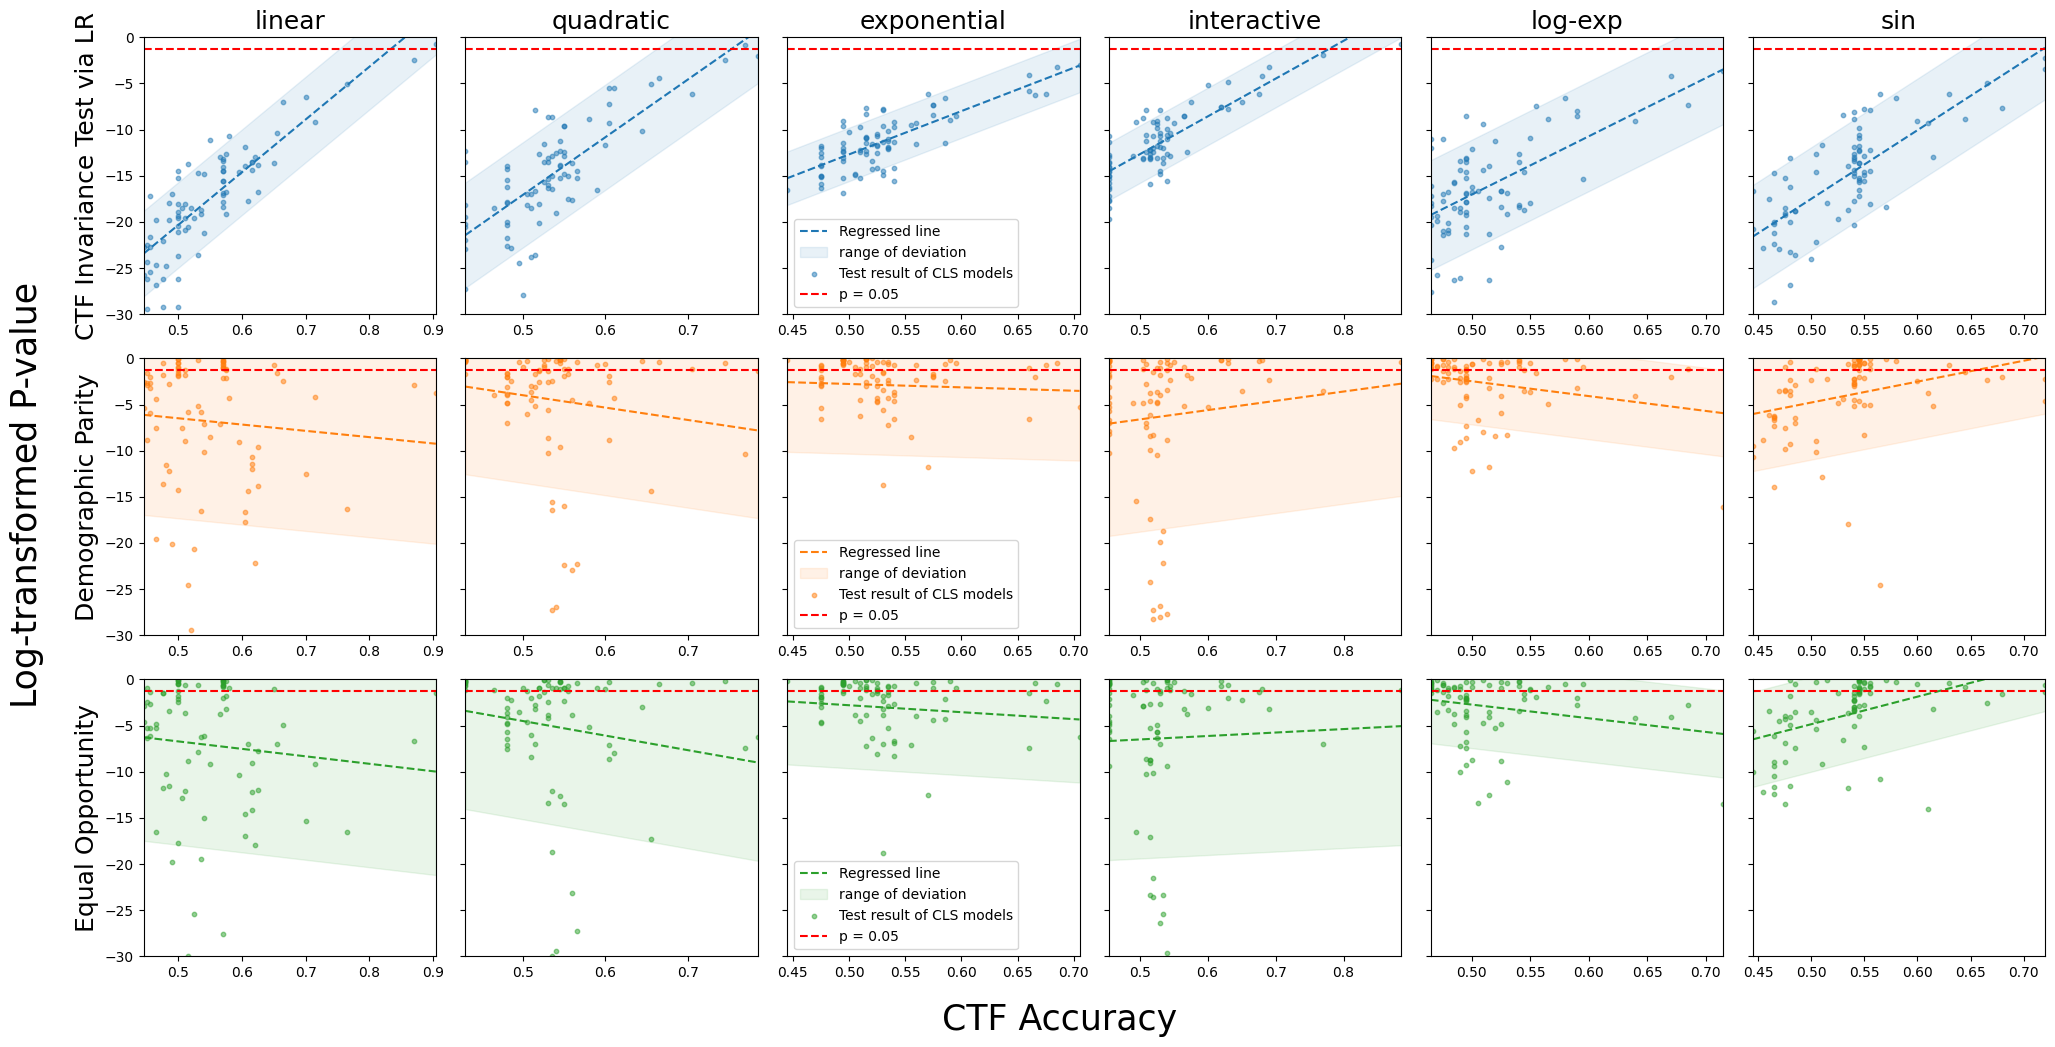

In [144]:
p_values_data = [linear_results, quad_results, exp_results, int_results, logexp_results, sin_results]
p_values_keys = ['CI Test', 'Demographic Parity', 'Equal Opportunity']
p_values_names = ['CTF Invariance Test via LR', 'Demographic Parity', 'Equal Opportunity']
# Set up a 3x5 subplot grid
fig, axes = plt.subplots(3, 6, figsize=(20, 10), sharex=False, sharey=True)
point_size = 10
y_limit = [-30, 0]     # For log-transformed p-values, adjust as needed
# Horizontal line for log(p = 0.05)
log_p_05 = np.log10(0.05)
Transformations = [r"linear", r"quadratic", r"exponential", r"interactive", r"log-exp", r"sin"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

# Loop over each p-value array and create subplots
for j, p_values_dict in enumerate(p_values_data):
    ctf_acc = np.array(p_values_dict["ECA"])
    for i, k in enumerate(p_values_keys):
        # Extract the p-values for the current column
        p_values_col = np.log10(np.array(p_values_dict[k])).squeeze()
        
        # Sort the values and apply moving average
        sorted_indices = np.argsort(ctf_acc)
        ctf_acc_sorted = ctf_acc[sorted_indices]
        p_values_sorted = p_values_col[sorted_indices]
        
        # Apply moving average smoothing
        #window_size = 20
        #p_values_smoothed, variance = moving_average_confidence_interval(p_values_sorted, window_size)
        #ctf_acc_adjusted = moving_average(ctf_acc_sorted, window_size)
        
        # Compute the confidence intervals (95% CI = mean ± 1.96 * std)
        #upper_ci = p_values_smoothed + 1.96 * variance
        #lower_ci = p_values_smoothed - 1.96 * variance
        slope, intercept = np.polyfit(ctf_acc_sorted, p_values_sorted, 1)
        p_values_fitted = slope * ctf_acc_sorted + intercept

        residuals = p_values_sorted - p_values_fitted
        std_residuals = np.std(residuals)
        upper_ci = p_values_fitted + 1.5 * std_residuals
        lower_ci = p_values_fitted - 1.5 * std_residuals
        
        # Plot the smoothed p-values with confidence intervals
        axes[i, j].plot(ctf_acc_sorted, p_values_fitted, 'b--', color = colors[i], label='Regressed line')
        axes[i, j].fill_between(ctf_acc_sorted, lower_ci, upper_ci, color = colors[i], alpha=0.1, label='range of deviation')
        axes[i, j].scatter(ctf_acc_sorted, p_values_sorted, c = colors[i], alpha=0.5,  s=point_size, label='Test result of CLS models')
        
        # Add horizontal line for p = 0.05 (log-transformed)
        axes[i, j].axhline(y=log_p_05, color='red', linestyle='--', label='p = 0.05')

        if j == 2:
            axes[i, j].legend()
        
        # Set subplot titles and labels
        if i == 0:
            axes[i, j].set_title(Transformations[j], fontsize = 18)
        if j == 0:
            axes[i, j].set_ylabel(f'{p_values_names[i]}', fontsize = 18)
        x_limit = (ctf_acc_sorted[0], ctf_acc_sorted[-1])
        axes[i, j].set_xlim(x_limit)
        axes[i, j].set_ylim(y_limit)

# Set shared x and y labels
fig.text(0.5, -0.035, 'CTF Accuracy', ha='center', fontsize=25)
fig.text(-0.025, 0.5, 'Log-transformed P-value', va='center', rotation='vertical', fontsize=25)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()